In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import gc
from math import radians,asin
from sklearn.metrics import mean_squared_error,explained_variance_score,mean_absolute_error
from sklearn.model_selection import KFold
import lightgbm as lgb
import seaborn
from tqdm import tqdm_notebook as tqdm
import numpy as np
import math
import os
import time
import json
import joblib
warnings.filterwarnings('ignore')

In [2]:
time_s=time.time()

#  def function

In [3]:
def creat_log_lat(df,type_str):
    if type_str=='dest':
        last_time_gps=df.groupby(['loadingOrder'])['timestamp'].max().reset_index()
    elif type_str=='ori':
        last_time_gps=df.groupby(['loadingOrder'])['timestamp'].min().reset_index()
    last_time_gps['id_time']=last_time_gps['loadingOrder'].astype(str)+last_time_gps['timestamp'].astype(str)
    
    df['id_time']=df['loadingOrder']+df['timestamp'].astype(str)

    gps_last_time=df.loc[df.id_time.isin(last_time_gps['id_time'])][['loadingOrder','longitude','latitude']]

    a=gps_last_time['loadingOrder']
    log_dest=gps_last_time['longitude']
    lat_dest=gps_last_time['latitude']
    log_dest_map={i:j for i,j in zip(a,log_dest)}
    lat_dest_map={i:j for i,j in zip(a,lat_dest)}

    df['log_'+type_str]=df['loadingOrder'].map(log_dest_map)
    df['lat_'+type_str]=df['loadingOrder'].map(lat_dest_map)
    
    df=df.drop(columns=['id_time'])
    return df

In [4]:
def get_val_score(m,df,df_s):
    fea_cols=[c for c in df_s.columns if c not in ['loadingOrder',  'timestamp', 'onboardDate','arrival_time','label','predict']]
    df_s['predict']=m.predict(df_s[fea_cols])
    pred_map={i:j for i,j in zip(df_s['loadingOrder'],df_s['predict'])}
    df['predict']=df['loadingOrder'].map(pred_map)
    score=mean_squared_error(df['label'],df['predict'])
    return score

In [5]:
def create_id_time(df):
    last_time_data=df.groupby(['loadingOrder'])['timestamp'].max().reset_index()
    last_time_data['id_time']=last_time_data['loadingOrder'].astype(str)+last_time_data['timestamp'].astype(str)
    
    df['id_time']=df['loadingOrder']+df['timestamp'].astype(str)
    
    df=df.drop_duplicates(['id_time'])
    
    return df,last_time_data

In [6]:
def calculate_last_gps_to_dest_dist(df,type_str):
    if type_str=='dest':
        last_time_gps=df.groupby(['loadingOrder'])['timestamp'].max().reset_index()
    elif type_str=='ori':
        last_time_gps=df.groupby(['loadingOrder'])['timestamp'].min().reset_index()
    last_time_gps['id_time']=last_time_gps['loadingOrder'].astype(str)+last_time_gps['timestamp'].astype(str)

    df['id_time']=df['loadingOrder']+df['timestamp'].astype(str)

    gps_last_time=df.loc[df.id_time.isin(last_time_gps['id_time'])][['loadingOrder','longitude','latitude','log_dest','lat_dest','log_ori','lat_ori']]
    gps_last_time['lon1']=gps_last_time['log_'+type_str].map(lambda x:np.radians(x))
    gps_last_time['lon2']=gps_last_time['longitude'].map(lambda x:np.radians(x))
    gps_last_time['lat1']=gps_last_time['lat_'+type_str].map(lambda x:np.radians(x))
    gps_last_time['lat2']=gps_last_time['latitude'].map(lambda x:np.radians(x))
    dlon=gps_last_time['lon1']-gps_last_time['lon2']
    dlat=gps_last_time['lat1']-gps_last_time['lat2']
    a=np.sin(dlat/2)**2+np.cos(gps_last_time['lat1'])*np.cos(gps_last_time['lat2'])*np.sin(dlon/2)**2
    dist=2*np.arcsin(np.sqrt(a))*6371
    if type_str=='dest':
        gps_last_time['last_gps_to_dest_dist']=dist
        last_gps_to_dest_dist_map={i:j for i,j in zip(gps_last_time['loadingOrder'],gps_last_time['last_gps_to_dest_dist'])}
        df['last_gps_to_dest_dist']=df['loadingOrder'].map(last_gps_to_dest_dist_map)
    else:
        gps_last_time['latest_gps_to_ori_dist']=dist
        latest_gps_to_ori_dist_map={i:j for i,j in zip(gps_last_time['loadingOrder'],gps_last_time['latest_gps_to_ori_dist'])}
        df['latest_gps_to_ori_dist']=df['loadingOrder'].map(latest_gps_to_ori_dist_map)
    df=df.drop(columns='id_time')
    return df

In [7]:
def geohash_encode(x, type_str,precision=3):
    """
    Encode a position given in float arguments latitude, longitude to
    a geohash which will have the character count precision.
    """
    if type_str=='dest':
         latitude, longitude=x['lat_dest'],x['log_dest']
    elif type_str=='ori':
        latitude, longitude=x['lat_ori'],x['log_ori']
    elif type_str=='curr':
        latitude, longitude=x['latitude'],x['longitude']
#     print(type(latitude),latitude)
    lat_interval, lon_interval = (-90.0, 90.0), (-180.0, 180.0)
    base32 = '0123456789bcdefghjkmnpqrstuvwxyz'
    geohash = []
    bits = [16, 8, 4, 2, 1]
    bit = 0
    ch = 0
    even = True
    while len(geohash) < precision:
        if even:
            mid = (lon_interval[0] + lon_interval[1]) / 2
            if longitude > mid:
                ch |= bits[bit]
                lon_interval = (mid, lon_interval[1])
            else:
                lon_interval = (lon_interval[0], mid)
        else:
            mid = (lat_interval[0] + lat_interval[1]) / 2
            if latitude > mid:
                ch |= bits[bit]
                lat_interval = (mid, lat_interval[1])
            else:
                lat_interval = (lat_interval[0], mid)
        even = not even
        if bit < 4:
            bit += 1
        else:
            geohash += base32[ch]
            bit = 0
            ch = 0
    return ''.join(geohash)

In [8]:
def find_first_time_to_dest_dist_about_100(df):
    
    def calculate_curr_to_dest_dist(df): 
        df['lon1']=df['log_dest'].map(lambda x:np.radians(x))
        df['lon2']=df['longitude'].map(lambda x:np.radians(x))
        df['lat1']=df['lat_dest'].map(lambda x:np.radians(x))
        df['lat2']=df['latitude'].map(lambda x:np.radians(x))
        dlon=df['lon1']-df['lon2']
        dlat=df['lat1']-df['lat2']
        a=np.sin(dlat/2)**2+np.cos(df['lat1'])*np.cos(df['lat2'])*np.sin(dlon/2)**2
        dist=2*np.arcsin(np.sqrt(a))*6371
        df['curr_to_dest_length']=dist
        drop_cols=['lon1','lon2','lat1','lat2']
        df.drop(columns=drop_cols,inplace=True)
        return df
    df=calculate_curr_to_dest_dist(df)
    
    df['curr_to_dest_length']=df['curr_to_dest_length'].astype(int)
    
#     df['hist_speed_mean']=df.groupby('loadingOrder')['speed'].transform('mean')
    
    df['curr_dist_minus_100']=np.abs(df['curr_to_dest_length']-50)
    
    a=df[df['curr_dist_minus_100']<50] # 只取距离港口100千米范围内的数据
    
    a=a.sort_values(['loadingOrder','curr_dist_minus_100','timestamp'])
#     print(a[['loadingOrder','curr_dist_minus_100','timestamp','curr_to_dest_length']])
    
    a=a.groupby('loadingOrder').head(5)[['loadingOrder','timestamp','curr_dist_minus_100']] # 选取候选的top5
    
    a=a.sort_values(['loadingOrder','timestamp'])
    a=a.groupby('loadingOrder').head(1)[['loadingOrder','timestamp','curr_dist_minus_100']] # 在候选top5里面选取时间最早的
    
    last_time_map={i:j for i,j in zip(a['loadingOrder'],a['timestamp'])}
    
    df['last_time']=df['loadingOrder'].map(last_time_map)
    
    df=df.loc[df['timestamp']<=df['last_time']]
    
    df=df.drop(columns=['curr_dist_minus_100','last_time'])
        
    return df

In [9]:
def calculate_curr_to_dest_dist(df): 
    df['lon1']=df['log_dest'].map(lambda x:np.radians(x))
    df['lon2']=df['longitude'].map(lambda x:np.radians(x))
    df['lat1']=df['lat_dest'].map(lambda x:np.radians(x))
    df['lat2']=df['latitude'].map(lambda x:np.radians(x))
    dlon=df['lon1']-df['lon2']
    dlat=df['lat1']-df['lat2']
    a=np.sin(dlat/2)**2+np.cos(df['lat1'])*np.cos(df['lat2'])*np.sin(dlon/2)**2
    dist=2*np.arcsin(np.sqrt(a))*6371
    df['curr_to_dest_length']=dist
    drop_cols=['lon1','lon2','lat1','lat2']
    df.drop(columns=drop_cols,inplace=True)
    return df

In [10]:
def cal_curr_direction(x):
    lon1=x['longitude']
    lat1=x['latitude']
    lon2=x['log_dest']
    lat2=x['lat_dest']
    lat1_rad = lat1 * np.pi / 180
    lon1_rad = lon1 * np.pi / 180
    
    lat2_rad = lat2 * np.pi / 180
    lon2_rad = lon2 * np.pi / 180
    
    y = np.sin(lon2_rad - lon1_rad) * math.cos(lat2_rad)
    x = np.cos(lat1_rad) * np.sin(lat2_rad) - np.sin(lat1_rad) * np.cos(lat2_rad) * np.cos(lat2_rad - lat1_rad)
    
    d = np.arctan2(y, x) * 180 / np.pi
    
    direction = float((d + 360) % 360)
    
    return direction

# 清洗port

In [11]:
port=pd.read_csv('./input/port.csv')

In [12]:
# 去除重名港口
port=port.drop_duplicates('TRANS_NODE_NAME').reset_index(drop=True)

In [13]:
port['TRANS_NODE_NAME']=port['TRANS_NODE_NAME'].astype(str).str.lower()

In [14]:
port_log_lat=port[['TRANS_NODE_NAME','LONGITUDE','LATITUDE']]

port_log_lat=port_log_lat.loc[~((port_log_lat.LONGITUDE==0.831116)&(port_log_lat.LATITUDE==-0.386592))]
port_log_lat=port_log_lat.loc[~((port_log_lat.LATITUDE==0.831116)&(port_log_lat.LONGITUDE==-0.386592))]

port_log_lat['lon1']=port_log_lat['LONGITUDE'].map(lambda x:np.radians(x))
port_log_lat['lat1']=port_log_lat['LATITUDE'].map(lambda x:np.radians(x))

# 读取GPS 

In [15]:
%%time
# 直接读取抽样后的数据
DEBUG=False
NROWS=200000


if not DEBUG:
    gps=pd.read_pickle('./input/gps_sample-8-10_BDC.pkl')
else:
    gps=pd.read_pickle('./input/gps_sample-7-19.pkl')
    gps=gps[:100]

gps.sort_values(['loadingOrder','timestamp'],inplace=True)
gps=gps.reset_index(drop=True)


test=pd.read_csv('./input/test_B.csv')
test.sort_values(['loadingOrder','timestamp'],inplace=True)
print("测试集B的长度：",len(test))

测试集B的长度： 57071
Wall time: 21.3 s


In [16]:
print(len(gps),gps.loadingOrder.nunique())

2613777 9934


In [17]:
sub=test[['loadingOrder','timestamp','longitude', 'latitude', 'carrierName','vesselMMSI','onboardDate']]

### 特征工程

In [18]:
gps=gps.drop(columns=['speed','vesselMMSI','direction'])
test=test.drop(columns=['speed','vesselMMSI','direction'])

In [19]:
# 处理一下时间格式
gps['timestamp']=pd.to_datetime(gps['timestamp'],infer_datetime_format=True,utc=True)
gps['onboardDate']=pd.to_datetime(gps['onboardDate'],infer_datetime_format=True,utc=True)
test['timestamp']=pd.to_datetime(test['timestamp'],infer_datetime_format=True,utc=True)
test['onboardDate']=pd.to_datetime(test['onboardDate'],infer_datetime_format=True,utc=True)

In [20]:
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.lower()
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.lower()


test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('cnytn','cnshk')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('shekou','cnshk')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('hkhkg','hkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('cnhkg','hkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('hongkong','hkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('ytn','hkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('ltklj-hk2_sf','hkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('hkgg kong_china','hkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('mtmal','mtmar')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('bu','buenosaires') # 这里会把下面的bu都匹配掉
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('hk2_sf','hkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('hk1_macaud','hkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('hk1_sino','hkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('hon','hkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('arbuenosairese','buenosaires')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('cobuenosairesn','buenosaires')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('buenosairesenosaires','buenosaires')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('cnshk','hkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('cnnsa','hkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('cvpra','cvrai')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('manzanillo_panama','paonx')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('panama','paonx')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('pacol','paonx')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('crpli','crlio')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('portoftanjungpelepas_malaysia','mytpp')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('nzakl','akl')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('sgsin','sin')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('cnsgh','shanghai')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('csh1_shhlw','shanghai')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('brsts','brssz')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('tza','bzbze')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('twkao','twkhh')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('cnkhs','twkhh')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('cndcw','hkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('cndcb','hkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('cndcb','cncwn')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('mylpk','mypkg')
test['TRANSPORT_TRACE']=test['TRANSPORT_TRACE'].str.replace('mywsp','mypkg')

gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('cnytn','cnshk')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('shekou','cnshk')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('hkhkg','hkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('cnhkg','hkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('hongkong','hkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('ytn','hkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('ltklj-hk2_sf','hkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('hkgg kong_china','hkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('mtmal','mtmar')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('bu','buenosaires')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('hk2_sf','hkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('hk1_macaud','hkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('hk1_sino','hkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('hon','hkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('arbuenosairese','buenosaires')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('cobuenosairesn','buenosaires')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('buenosairesenosaires','buenosaires')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('cnshk','hkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('cnnsa','hkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('cvpra','cvrai')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('manzanillo_panama','paonx')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('panama','paonx')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('pacol','paonx')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('crpli','crlio')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('portoftanjungpelepas_malaysia','mytpp')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('nzakl','akl')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('sgsin','sin')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('cnsgh','shanghai')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('csh1_shhlw','shanghai')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('brsts','brssz')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('tza','bzbze')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('twkao','twkhh')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('cnkhs','twkhh')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('cndcw','hkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('cndcb','hkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('cndcb','cncwn')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('mylpk','mypkg')
gps['TRANSPORT_TRACE']=gps['TRANSPORT_TRACE'].str.replace('mywsp','mypkg')

gps['ori_port']=gps['TRANSPORT_TRACE'].map(lambda x: str(x).split('-')[0])
gps['dest_port']=gps['TRANSPORT_TRACE'].map(lambda x: str(x).split('-')[-1])

test['ori_port']=test['TRANSPORT_TRACE'].map(lambda x: str(x).split('-')[0])
test['dest_port']=test['TRANSPORT_TRACE'].map(lambda x: str(x).split('-')[-1])

In [21]:
gps_trance=gps.TRANSPORT_TRACE.unique().tolist()

test['TRANSPORT_TRACE']=test.TRANSPORT_TRACE.str.lower()
test_trance=test.TRANSPORT_TRACE.unique().tolist()

ans=[]
for c in test_trance:
    if c not in gps_trance:
        ans.append(c)
print(len(ans),ans)

1 ['cnsha-sin']


In [22]:
port_name=port.TRANS_NODE_NAME
port_log=port.LONGITUDE
port_lat=port.LATITUDE
log_dest_map={i:j for i,j in zip(port_name,port_log)}
lat_dest_map={i:j for i,j in zip(port_name,port_lat)}


test['log_dest']=test['dest_port'].map(log_dest_map)
test['lat_dest']=test['dest_port'].map(lat_dest_map)
test['log_ori']=test['ori_port'].map(log_dest_map)
test['lat_ori']=test['ori_port'].map(lat_dest_map)

gps['log_dest']=gps['dest_port'].map(log_dest_map)
gps['lat_dest']=gps['dest_port'].map(lat_dest_map)
gps['log_ori']=gps['ori_port'].map(log_dest_map)
gps['lat_ori']=gps['ori_port'].map(lat_dest_map)

上图是训练集的分布和测试集最后一条记录形成的分布图,红色测试集，蓝色训练集

In [23]:
# 单号 FA712454830300 数据数据异常，单独处理
test=calculate_curr_to_dest_dist(test)
a=test[test.loadingOrder=='FA712454830300']
test=test.loc[~test.loadingOrder.isin(['FA712454830300'])]
a=a.loc[a.curr_to_dest_length==a.curr_to_dest_length.min()]
test=test.append(a)
test=test.drop(columns='curr_to_dest_length')

In [24]:
def process_diff_log(diff):
    return diff if diff < 180 else 360 - diff
    
gps['diff_log_from_current_to_dest'] = abs(gps['log_dest'] - gps['longitude'])
gps['diff_log_from_current_to_dest'] = gps['diff_log_from_current_to_dest'].apply(process_diff_log)
gps['diff_lat_from_current_to_dest'] = abs(gps['lat_dest'] - gps['latitude'])

test['diff_log_from_current_to_dest'] = abs(test['log_dest'] - test['longitude'])
test['diff_log_from_current_to_dest'] = test['diff_log_from_current_to_dest'].apply(process_diff_log)
test['diff_lat_from_current_to_dest'] = abs(test['lat_dest'] - test['latitude'])


In [25]:
%%time
# 给当前位置，目的地，出发地做一个geohash
gps['curr_pos_geohash_3']=gps[['latitude','longitude']].apply(geohash_encode,args=('curr',3),axis=1)
test['curr_pos_geohash_3']=test[['latitude','longitude']].apply(geohash_encode,args=('curr',3),axis=1)

gps['curr_pos_geohash_4']=gps[['latitude','longitude']].apply(geohash_encode,args=('curr',4),axis=1)
test['curr_pos_geohash_4']=test[['latitude','longitude']].apply(geohash_encode,args=('curr',4),axis=1)

gps['dest_geohash']=gps[['lat_dest','log_dest']].apply(geohash_encode,args=('dest',3),axis=1)
test['dest_geohash']=test[['lat_dest','log_dest']].apply(geohash_encode,args=('dest',3),axis=1)

gps['hash_curr3_dest']=gps['curr_pos_geohash_3']+'-'+gps['dest_geohash']
test['hash_curr3_dest']=test['curr_pos_geohash_3']+'-'+test['dest_geohash']


Wall time: 7min 10s


In [26]:
gps['log_curr_dest_diff']=gps['longitude']-gps['log_dest']
test['log_curr_dest_diff']=test['longitude']-test['log_dest']

gps['lat_curr_dest_diff']=gps['latitude']-gps['lat_dest']
test['lat_curr_dest_diff']=test['latitude']-test['lat_dest']

gps['log_curr_ori_diff']=gps['longitude']-gps['log_ori']
test['log_curr_ori_diff']=test['longitude']-test['log_ori']

gps['lat_curr_ori_diff']=gps['latitude']-gps['lat_ori']
test['lat_curr_ori_diff']=test['latitude']-test['lat_ori']

In [27]:
# 中转港个数
gps['trance_str_len']=gps['TRANSPORT_TRACE'].map(lambda x:len(x.split('-')))
test['trance_str_len']=test['TRANSPORT_TRACE'].map(lambda x:len(x.split('-')))

In [28]:
gps=gps.drop(columns=['lat_ori','log_ori','ori_port'])
test=test.drop(columns=['lat_ori','log_ori','ori_port'])

In [29]:
# 将测试集和训练集合并，一起处理类别特征
trn_len=len(gps)

gps=gps.append(test)   # 这样append也可以是train test的columns顺序一直
gps=gps.reset_index(drop=True)


cate_features=[]
for c in gps.columns:
    if gps[c].dtype=='object' and c not in ['loadingOrder','timestamp']:
        cate_features.append(c)
        gps[c]=gps[c].astype('category').cat.codes
print(cate_features)
    
test=gps[trn_len:]
gps=gps[:trn_len]
gc.collect()

test.drop(columns=['label'],inplace=True)

gps=gps.reset_index(drop=True)
test=test.reset_index(drop=True)

['TRANSPORT_TRACE', 'carrierName', 'curr_pos_geohash_3', 'curr_pos_geohash_4', 'dest_geohash', 'dest_port', 'hash_curr3_dest']


### 分离训练集和验证集

In [30]:
test.to_pickle('./input/test_B_features_7-19.pkl')

In [31]:
# 分出标签并保存一些中间信息，便于后面操作
y=gps['label']

gps=gps.drop(columns=['loadingOrder', 'timestamp', 'onboardDate','label'])

test_id_time=test[['loadingOrder','timestamp']]
test=test.drop(columns=['loadingOrder','timestamp', 'onboardDate'])

In [32]:
print(len(gps.columns),gps.columns)
print(len(test.columns),test.columns)

18 Index(['TRANSPORT_TRACE', 'carrierName', 'curr_pos_geohash_3',
       'curr_pos_geohash_4', 'dest_geohash', 'dest_port',
       'diff_lat_from_current_to_dest', 'diff_log_from_current_to_dest',
       'hash_curr3_dest', 'lat_curr_dest_diff', 'lat_curr_ori_diff',
       'lat_dest', 'latitude', 'log_curr_dest_diff', 'log_curr_ori_diff',
       'log_dest', 'longitude', 'trance_str_len'],
      dtype='object')
18 Index(['TRANSPORT_TRACE', 'carrierName', 'curr_pos_geohash_3',
       'curr_pos_geohash_4', 'dest_geohash', 'dest_port',
       'diff_lat_from_current_to_dest', 'diff_log_from_current_to_dest',
       'hash_curr3_dest', 'lat_curr_dest_diff', 'lat_curr_ori_diff',
       'lat_dest', 'latitude', 'log_curr_dest_diff', 'log_curr_ori_diff',
       'log_dest', 'longitude', 'trance_str_len'],
      dtype='object')


# model

In [33]:
if not DEBUG:
    n_estimators=3555
else:
    n_estimators=200

In [34]:
random_state_seed=2020

In [35]:
best_hp={'boosting_type': 'gbdt',
 'num_leaves': 120,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': n_estimators,
 'subsample_for_bin': 200000,
 'objective': 'mse',
 'min_split_gain': 0,
 'min_child_weight': 0.001,
 'min_child_samples': 4,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1,
 'reg_alpha': 0.12740601081135802,
 'reg_lambda': 0.056415310666309004,
 'n_jobs': 16,
#  'silent': True,
 'importance_type': 'split',
 'random_state':2020}

In [36]:
%%time
feature_importance=pd.DataFrame(columns=['features','importance'])
feature_importance['features']=gps.columns
feature_importance['importance']=0
oof = np.zeros((gps.shape[0]))
# val_pre = np.zeros((val_x.shape[0]))
prediction = np.zeros((test.shape[0]))
# seeds = [123456, 87654, 676767]
seeds = [2020, 1995, 810236]
score=0
num_model_seed = 1
for model_seed in range(num_model_seed):
    print("开始训练第%d个模型：" % (model_seed + 1))
    oof_cat = np.zeros((gps.shape[0]))
    prediction_cat = np.zeros((test.shape[0]))
    feature_importance_cat=np.zeros((feature_importance.shape[0]))
    skf = KFold(n_splits=5, random_state=seeds[model_seed], shuffle=True) # 这里是否需要shuffle，因为数据是进过排序好的，不shuffle，那么按照顺序切割了 
    for index, (train_index, test_index) in enumerate(skf.split(gps, y)):
        print("正在训练第%d折" % (index + 1))
        train_x, test_x, train_y, test_y = gps.iloc[train_index], gps.iloc[test_index], y.iloc[train_index], \
                                           y.iloc[test_index]
        gc.collect()
        m = lgb.LGBMRegressor().set_params(**best_hp)
        m.fit(train_x, train_y, eval_metric='mse', eval_set=[(train_x,train_y),(test_x,test_y)],verbose=100,early_stopping_rounds=200,categorical_feature=cate_features)
        model_name='./model/model_'+str(index)+'_'+str(model_seed)+'.pkl'
        joblib.dump(m,model_name)
        feature_importance_cat+=m.feature_importances_ / skf.n_splits
        oof_cat[test_index] += m.predict(test_x)
#         val_pre += m.predict(val_x) / skf.n_splits
        prediction_cat += m.predict(test) / skf.n_splits
        gc.collect()

    feature_importance['importance']+=feature_importance_cat/num_model_seed
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
    
    print(f'oof mse:{mean_squared_error(y, oof_cat)},oof mae:{mean_absolute_error(y,oof_cat)}')

    
print("*" * 30)
print('oof mse', mean_squared_error(y, oof))
# print('oof mae',mean_absolute_error(y,oof_cat))

开始训练第1个模型：
正在训练第1折
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 2261.58	valid_1's l2: 2441.01
[200]	training's l2: 2051.4	valid_1's l2: 2331.2
[300]	training's l2: 1939.07	valid_1's l2: 2281.49
[400]	training's l2: 1867.88	valid_1's l2: 2258.77
[500]	training's l2: 1808.91	valid_1's l2: 2245.11
[600]	training's l2: 1761.5	valid_1's l2: 2234.24
[700]	training's l2: 1719.28	valid_1's l2: 2223.46
[800]	training's l2: 1685.41	valid_1's l2: 2226.21
[900]	training's l2: 1654.34	valid_1's l2: 2222.48
[1000]	training's l2: 1629.07	valid_1's l2: 2219.55
[1100]	training's l2: 1603.93	valid_1's l2: 2217.17
[1200]	training's l2: 1582.04	valid_1's l2: 2217.7
[1300]	training's l2: 1559.92	valid_1's l2: 2217.29
[1400]	training's l2: 1538.98	valid_1's l2: 2217.49
Early stopping, best iteration is:
[1262]	training's l2: 1569.56	valid_1's l2: 2215.83
正在训练第2折
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 2275.99	valid_1's l2: 2455

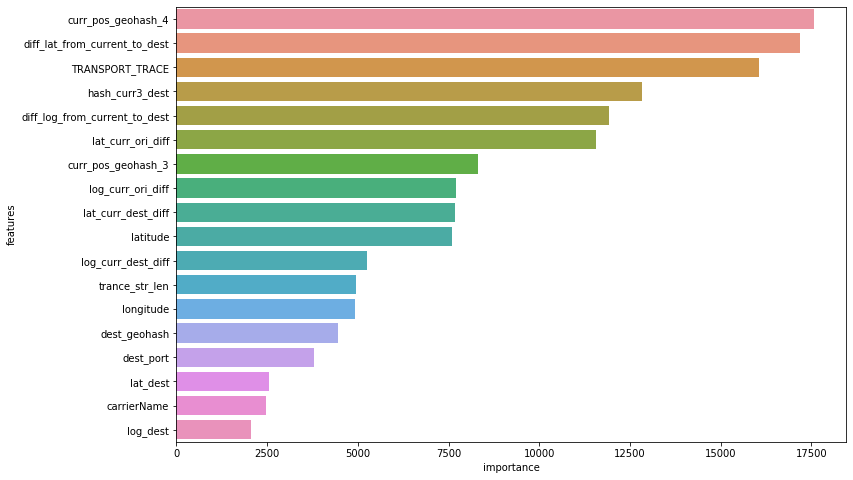

In [37]:
feature_importance.sort_values(['importance'],inplace=True,ascending=False)
feature_importance=feature_importance.reset_index(drop=True)
fig=plt.figure(figsize=(12,8))
sns.barplot(x='importance',y='features',data=feature_importance)

In [38]:
test['loadingOrder']=test_id_time['loadingOrder']
test['timestamp']=test_id_time['timestamp']
# test['predict']=np.expm1(prediction)
test['predict']=prediction

predict_map={i:j for i,j in zip(test['loadingOrder'],test['predict'])}

test['ETA']=(test['timestamp'] + test['predict'].apply(lambda x:pd.Timedelta(hours=x))).apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))

test=test.sort_values(['loadingOrder','timestamp'])

test[['loadingOrder','timestamp','predict']].to_csv('./test_for_mnerge.csv',index=False)

test_tail=test.groupby('loadingOrder').tail(1)
test_head=test.groupby('loadingOrder').head(1)

ETA_map_tail={i:j for i,j in zip(test_tail['loadingOrder'],test_tail['ETA'])}
ETA_map_head={i:j for i,j in zip(test_head['loadingOrder'],test_head['ETA'])}

sub['ETA'] = sub['loadingOrder'].map(ETA_map_tail)

sub['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')

sub.to_csv('./output/sub_8-9-1_model719_b-5.csv',index=False)

In [39]:
time_e=time.time()
print("total time:",(time_e-time_s)/3600)

total time: 0.5329665099249946
